In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms --> 토치비전에서 제공되는 걸 활용하면 됌.
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

In [6]:
#data loader
#num_workers = 2라는 말은, cpu 코어 하나로 처리하던 것을 멀티코어로 변경해서 처리해서, GPU에 전달하는 기능
# 이는 머신러닝의 학습속도를 더욱 빠르게 만들어준다.
trainloader = DataLoader(trainset, batch_size = 4, shuffle= True, num_workers = 2)
#testloader 에서 shuffle을 False로 하는 이유?
testloader = DataLoader(testset, batch_size = 4, shuffle= False, num_workers= 2)


In [7]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # (N, 1, 28, 28) --> 배치사이즈, 인풋개수, 28 by 28
        self.conv1 = nn.Conv2d(1,6,5) # 여기서 5는 stride의 크기를 말해줍니다.
        self.pool = nn.MaxPool2d(2,2) # 2 by 2로 크기를 줄여주겠다.
        # (N, 6, 12, 12)
        self.conv2 = nn.Conv2d(6,16,5)
        # (N, 16, 4, 4)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4) # fully-connectd 에서는 2차원 형태로 데이터 변환
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 1e-4, momentum=0.9)

# 1. Tensor Board 설정 

1) 텐서보드를 사용하는 이유는 우리의 모든 loss나 accuracy를 기록할 수 있기 떄문에 시각화 측면에서 굉장히 효율적

2) tensorboard 설치도 잘되고 했는데, 문제는 쥬피터에서 제대로 파일이 올라가지질 않는다. --> 구글링 결과, UTF-8 error라는 단서만 가지고는 이해할 수 없다.

3) 알게된점은 num_workers 를 통해서 CPU를 몇개 사용할 것인지를 결정할 수 있다는 점

4) test를 시작할떄, model.eval()를 선언해주어야 한다. 이를 통해 모든 layer들이 평가가 시작됌을 알 수 있고,  (eval 모드에서는 dropout은 비활성화, 배치 정규화는 학습에서 저장된 파라미터를 사용)

5) dropout이란 무엇인가?
학습된 임의의 뉴런의 연결을 끊어서 더 잘 학습되게 하는 것 --> 다른 뉴런들이 더 많은 학습을 하게 된다 --> (test 때는 모든 데이터를 다 사용한다)

In [38]:
from torch.utils.tensorboard import SummaryWriter
#기본 디렉토리가 runs
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/igyuseog/opt/anaconda3/lib/python3.8/multiprocessing/co

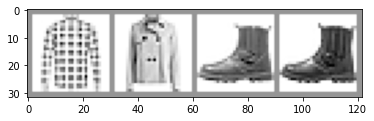

In [39]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [40]:
# 아래 명령어를 터미널에서 입력한다.
# tensorboard --logdir=runs
# 그리고 명령어가 다 완료되면, http://localhost:6006/ 입력한다.

In [41]:
writer.add_graph(net, images)
writer.close()

In [42]:
def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


In [62]:
running_loss = 0.0
for epoch in range(5):  # 데이터셋을 여러번 반복

    for i, data in enumerate(trainloader, 0):

        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 3000 == 2999:    # 매 1000 미니배치마다...
            print("step:{}, loss:{}".format(i+1, loss.item()))

            # ...학습 중 손실(running loss)을 기록하고
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
            # Matplotlib Figure를 기록합니다
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
            
            
            # 테스트를 넣어봤습니다.
        if i % 5000 == 4999:
            acc = 0
            with torch.no_grad():
                for idx, data in enumerate(testloader):
                    images, labels = data
                    output = net(images)

                    loss = criterion(output,labels)
                    _, indices = torch.max(output, 1)

                    acc += torch.sum(indices == labels).item()

                print('*'*20, 'Test', '*'*20)
                print('Step: {}, Loss: {}, Accuracy: {} %'.format(i+1, loss.item(), acc/100))
                print('*'*46)

        
print('Finished Training')

step:3000, loss:0.055288542062044144
******************** Test ********************
Step: 5000, Loss: 0.19438707828521729, Accuracy: 79.51 %
**********************************************
step:6000, loss:0.7236815690994263
step:9000, loss:0.23846079409122467
******************** Test ********************
Step: 10000, Loss: 0.2681444585323334, Accuracy: 80.45 %
**********************************************
step:12000, loss:0.43446364998817444
step:15000, loss:0.42415666580200195
******************** Test ********************
Step: 15000, Loss: 0.21024127304553986, Accuracy: 80.61 %
**********************************************
step:3000, loss:0.5287867784500122
******************** Test ********************
Step: 5000, Loss: 0.17248135805130005, Accuracy: 79.54 %
**********************************************
step:6000, loss:0.4736354351043701
step:9000, loss:0.5829308032989502
******************** Test ********************
Step: 10000, Loss: 0.1514381468296051, Accuracy: 81.35 %
****